In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.color'] = 'r'
plt.rcParams['font.size'] = 15
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 10
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams['axes.titlesize'] = 24
plt.rcParams['figure.figsize'] = 13, 13
from IPython.display import Image

In [4]:
def normalize(array):
    '''
    Given an array, this function normalizes the array by a sum
    '''    
    return np.array([x/sum(array) for x in array])

# Chapter 5: Bayes' Rule

Bayes' theorem describes the probability of an event based on the prior knowledge of another event that is related to the original event. 

$$p(A|B) = \frac{p(B|A)p(A)}{p(B)}$$


## Example

In a population, the probability of getting a disease is 0.001. We designate a parameter $\theta$ as either D (diseased) or H (healthy). Thus, $p(\theta = D) = 0.001$. There is a test, T, such that if an individual has the disease, the test result is positive (+) 99% of the time. The test also has a false positive rate of 5%, meaning that the test indicates positive when the sample is healthy 5% of the times. Thus, $p(T = + | \theta = D) = 0.99$ and  $p(T = + | \theta = H) = 0.05$.

We would like to figure out the probability of having the disease given a positive test result or the *posterior probability* of having the disease. 


![Alt text](5-table.png)

$$p(\theta = D | T = + ) = \frac{p( T = + |\theta = D)p(\theta = D)}{p(T = +)} = \frac{0.99 * 0.001}{0.99 * 0.001 + 0.05 * (1 - 0.001)} = 0.019$$

Given a positive test result, the probability of having the disease is 1.9%.

## Parameters and Data

Given a parameter $\theta$ and data D, $p(\theta|D) = \frac{p(D|\theta)p(\theta)}{p(D)}$

1. $p(\theta)$ = prior - creditibility of the parameter without the data
2. $p(\theta|D)$ = posterior - creditbility of the parameter with the data
3. $p(D|\theta)$ = likelihood - probability of generating the data D given the parameter
4. $p(D)$ = data or marginal likelihood - probability of the data without the parameter

All data is equally representative during the underlying process. The order of the data does not affect the final outcome.

## Estimating the Bias in a Coin

A fair coin is one in which the probability of heads is 50%. How do you find the probability of heads in a biased coin? Our sample space is $\Omega = $ [1,0]. y = 1 represents a flip of heads and y = 0 is tails. 

### 1. Build a model

The first step is to build a model, or likelihood function, with respect to some parameter, $\theta$, which represents the probability of flipping a heads. The model must allow for$p(y=1\vert \theta) = \theta$ and $p(y=0\vert \theta) = 1 - \theta$ to be true. The bernoulli distribution is one such model:

$$p(y \vert \theta) = \theta^y(1-\theta)^{1-y}$$

Notice that if y = 0, $p(y = 0 \vert \theta) = 1 - \theta$ and if y = 1, $p(y = 1 \vert \theta) = \theta$.

### 2. Prior Probability

The next step is to define a function for the prior probability. Let's assume that the bias of the coin can only take the values $\theta = 0$, $\theta = 0.1$, $\theta = 0.2$ and so on. We most believe that the coin is fair and thus give it the largest prior probability. As the bias increases, we decrease the probability. The prior probability is shown below.

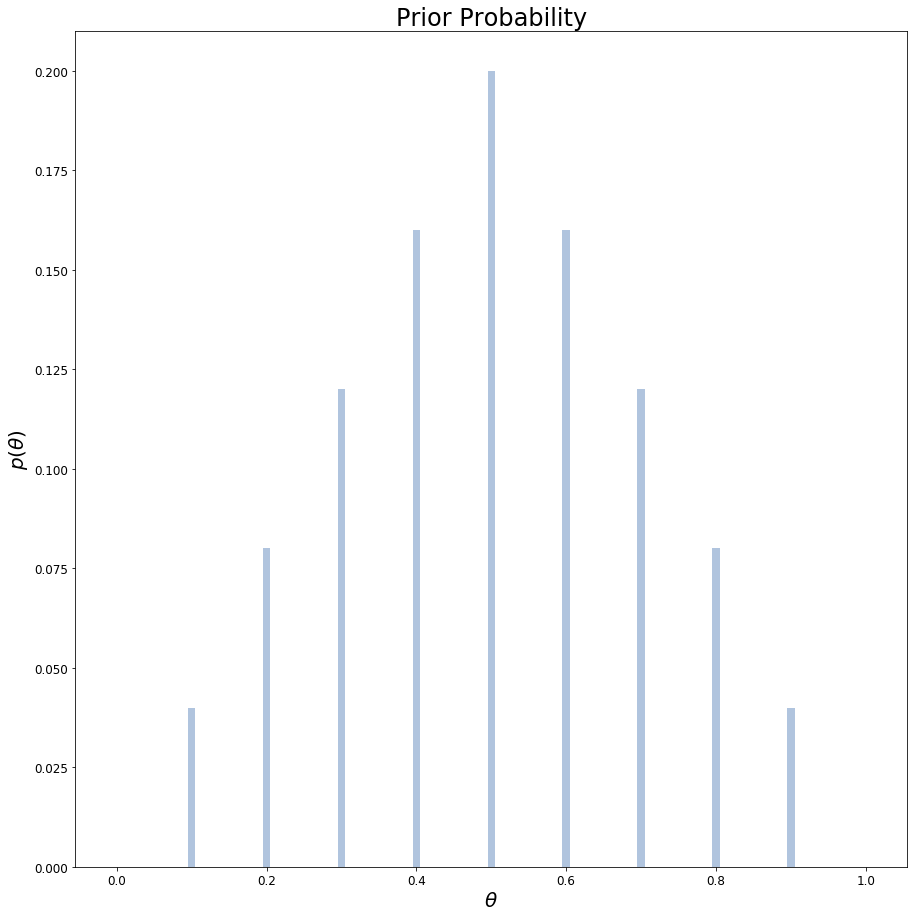

In [8]:
import numpy as np
from scipy.stats import triang

# possible values of theta - only 11 possible values
thetas = np.linspace(0,1,11)

# prior probability is a triangle distribution
prior = normalize(triang.pdf(thetas,0.5))

fig, ax = plt.subplots()

ax.bar(thetas,prior, width = 0.01, color = 'lightsteelblue')
ax.set_xlabel(r'$\theta$')
ax.set_ylabel(r'$p(\theta)$')
ax.set_title('Prior Probability')

fig.tight_layout()

### 3. Data Collection and Bayes' Rule

The next step is to create data and then to re-allocate credibility among the parameter values based on the data. Assume we flip the coin once and y = 1, notated as z = 1 and N = 1. Using the likelihood function above, we plot the reallocations below

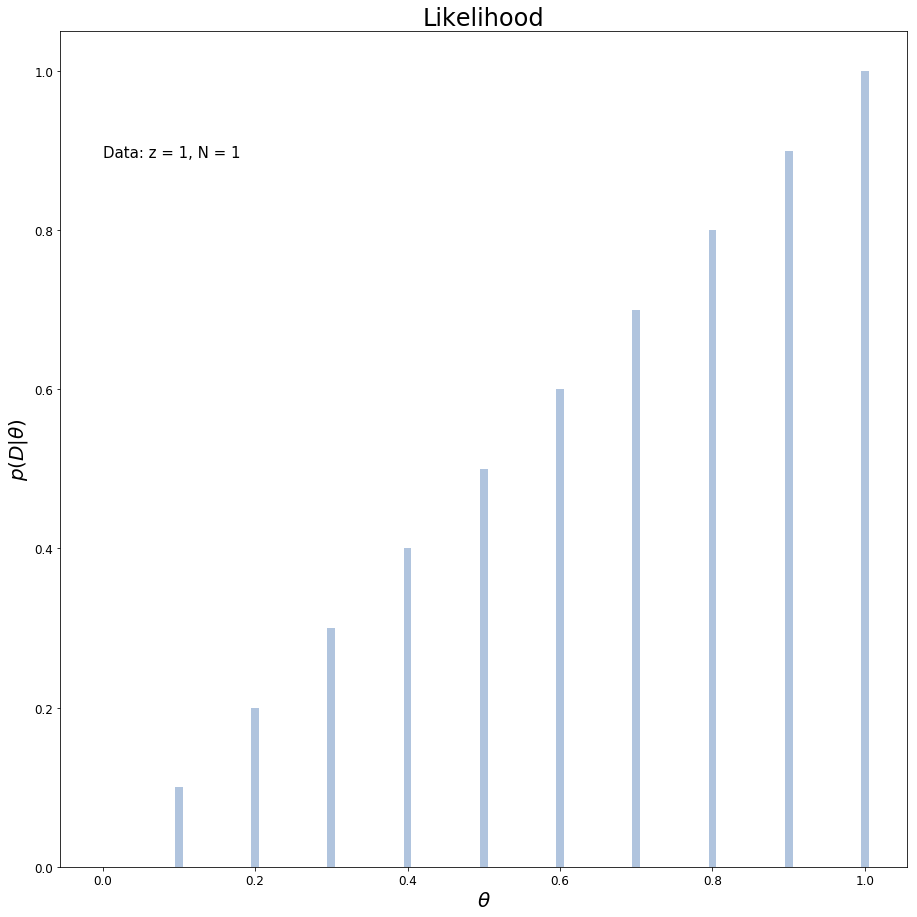

In [9]:
from scipy.stats import binom

# likelihood function is a binomial distribution
likelihood = binom.pmf(k = 1, n = 1, p = thetas)

fig, ax = plt.subplots()

ax.bar(thetas,likelihood, width = 0.01, color = 'lightsteelblue')

annot = 'Data: z = 1, N = 1'
ax.annotate(annot, xy=(0.05,0.85), xycoords="axes fraction")

ax.set_xlabel(r'$\theta$')
ax.set_ylabel(r'$p(D \vert \theta)$')
ax.set_title('Likelihood')

fig.tight_layout()

### 4. Posterior Probability

The next step is to calculate the posterior probability using Bayes Rule.

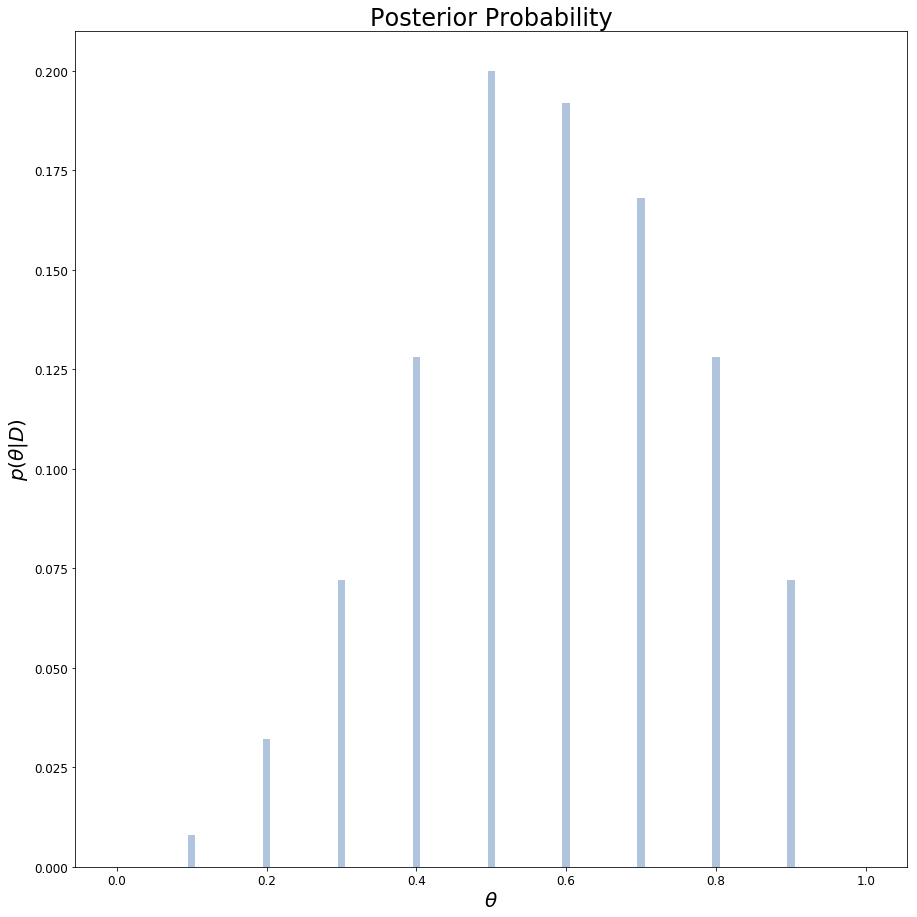

In [10]:
# Calculate posterior probability using Bayes' rule
prob_data = sum(np.multiply(prior,likelihood))
posterior = np.multiply(prior,likelihood) / prob_data

fig, ax = plt.subplots()

ax.bar(thetas,posterior, width = 0.01, color = 'lightsteelblue')

ax.set_xlabel(r'$\theta$')
ax.set_ylabel(r'$p(\theta \vert D)$')
ax.set_title('Posterior Probability')

fig.tight_layout()

### Influence of Sample Size

As expected, larger sample sizes yield a greater certainty in the estimation. This is true even if the ratio between coin flips is the same. An example is shown below with 4 flips, 40 flips, and 400 flips. We also test 1000 values of $\theta$ and use a beta distribution as our prior.

In [11]:
import pymc3 as pm
# possible values of theta - 1001 possible values
# shape parameters for beta distribution
a = 2
b = 2

# 3 experiments of different sample size
Ns = [4,40,400]
traces = []
# get samples with beta prior and a binomial likelihood
for x in range(3):
    with pm.Model() as model: # context management
        # number of samples
        samples = 1000
        # define priors
        p = pm.Beta('p', a, b)

        # define likelihood
        y = pm.Binomial('y', n=Ns[x], p=p, observed=0.25 * Ns[x])

        traces.append(pm.sample(samples, progressbar=False));

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [p_logodds__]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [p_logodds__]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [p_logodds__]


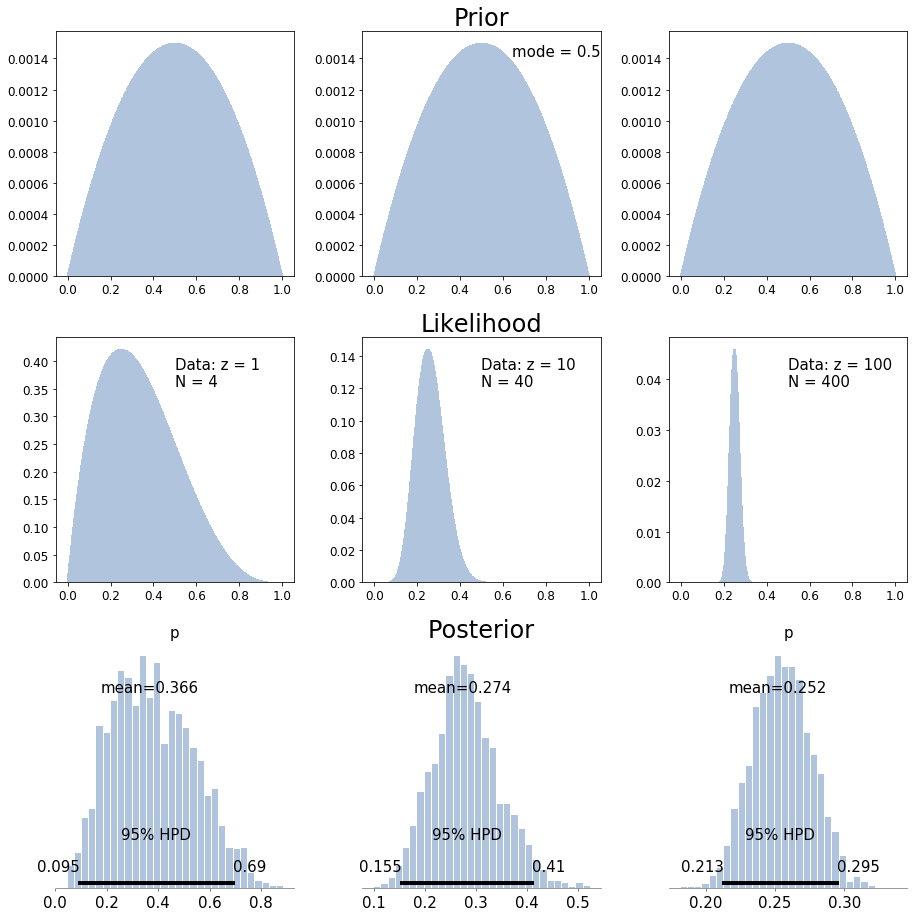

In [12]:
from scipy.stats import beta
thetas = np.linspace(0,1,1001)

fig, axs = plt.subplots(3,3)
annot = 'mode = 0.5'    
axs[0,1].annotate(annot, xy=(0.63,0.9), xycoords="axes fraction")


for grid in range(3):
    axs[0,grid].bar(thetas, normalize(beta.pdf(thetas, a = a,b =  b)), label='prior', width = 0.01, color = 'lightsteelblue');
    axs[1,grid].bar(thetas,binom.pmf(k = 0.25 * Ns[grid],n = Ns[grid], p = thetas), width = 0.01, color = 'lightsteelblue')
    annot = 'Data: z = ' + str(int(Ns[grid]*0.25)) + '\nN = ' + str(Ns[grid])
    axs[1,grid].annotate(annot, xy=(0.5,0.8), xycoords="axes fraction")      
    pm.plots.plot_posterior(traces[grid], label='post', color = 'lightsteelblue', ax = axs[2,grid])
    
axs[0,1].set_title('Prior')
axs[1,1].set_title('Likelihood')
axs[2,1].set_title('Posterior')
fig.tight_layout()

Notice how the highest posterior density shrinks as more data is included in the model. The estimated mean also moves closer to the actual value of 0.25. 

### Influence of Prior

One of the biggest factors in finding a credible parameter value is the prior information about the parameter. Below is an example of two posterior probabilities with a uniform and beta prior.

In [23]:
# number of trials in experiment
N = 4
# number of heads
z = 1
# shape parameters for beta distribution
a = 2
b = 2

# get samples of posterior from beta prior
with pm.Model() as model: # context management
    # number of samples
    samples = 1000
    # define priors
    p = pm.Beta('p', a,b)

    # define likelihood
    y = pm.Binomial('y', n=N, p=p, observed=z)

    trace_beta = pm.sample(samples, progressbar=False);

# get samples of posterior from uniform prior    
with pm.Model() as model: # context management
    # number of samples
    samples = 1000
    # define priors
    p = pm.Uniform('p', 0, 1)

    # define likelihood
    y = pm.Binomial('y', n=N, p=p, observed=z)

    trace_uniform = pm.sample(samples, progressbar=False);

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [p_logodds__]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [p_interval__]


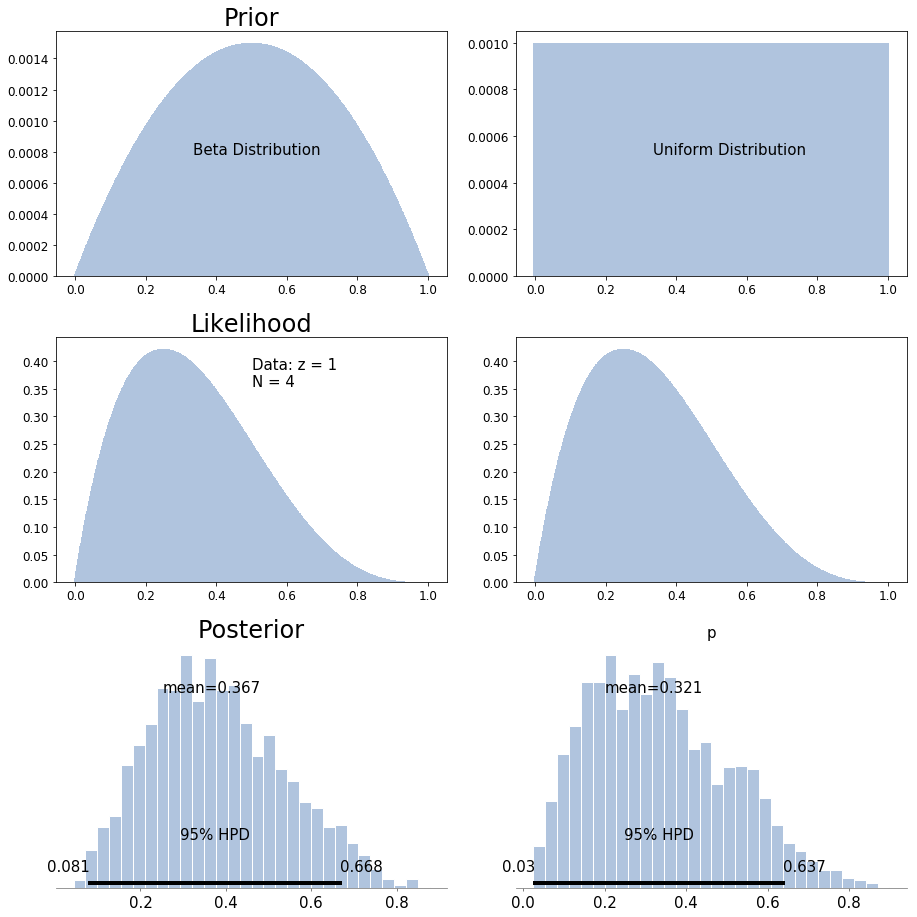

In [24]:
from scipy.stats import uniform

fig, axs = plt.subplots(3,2)

axs[0,0].bar(thetas, normalize(beta.pdf(thetas,a,b)), label='prior', width = 0.01, color = 'lightsteelblue');
axs[1,0].bar(thetas,binom.pmf(k = z,n = N, p = thetas), width = 0.01, color = 'lightsteelblue')
axs[0,0].annotate('Beta Distribution', xy=(0.35,0.5), xycoords="axes fraction")      
axs[1,0].annotate('Data: z = ' + str(z) + '\nN = ' + str(N), xy=(0.5,0.8), xycoords="axes fraction")      
pm.plots.plot_posterior(trace_beta, label='post', color = 'lightsteelblue', ax = axs[2,0])

axs[0,1].bar(thetas, normalize(uniform.pdf(thetas,0,1)), label='prior', width = 0.01, color = 'lightsteelblue');
axs[0,1].annotate('Uniform Distribution', xy=(0.35,0.5), xycoords="axes fraction")      
axs[1,1].bar(thetas,binom.pmf(k = z,n = N, p = thetas), width = 0.01, color = 'lightsteelblue')
pm.plots.plot_posterior(trace_uniform, label='post', color = 'lightsteelblue', ax = axs[2,1])

axs[0,0].set_title('Prior')
axs[1,0].set_title('Likelihood')
axs[2,0].set_title('Posterior')
fig.tight_layout()

# Chapter 5: Exercises

## Excercise 5.1

[Purpose: Iterative application of Bayes’ rule, and seeing how posterior probabilities change with inclusion of more data.] This exercise extends the ideas of Table 5.4, so at this time, please review Table 5.4 and its discussion in the text. Suppose that the same randomly selected person as in Table 5.4 gets re-tested after the first test result was positive, and on the re-test, the result is negative. When taking into account the results of both tests, what is the probability that the person has the disease? Hint: For the prior probability of the re-test, use the posterior computed from the Table 5.4. Retain as many decimal places as possible, as rounding can have a surprisingly big effect on the results. One way to avoid unnecessary rounding is to do the calculations in R.

In [48]:
p_disease = 0.001 # P(D)
p_clean = (1 - p_disease) # P(H)
p_true_pos = 0.99 # P(+|D)
p_false_neg = (1 - p_true_pos) # P(-|D)
p_false_pos = 0.05 # P(+|H)
p_true_neg = (1 - p_false_pos) # P(-|H)

In [49]:
# P(D|+) = P(+|D)*P(D) / P(+)

liklihood = p_true_pos
prior = p_disease
marginal_likelihood = (p_true_pos * p_disease) + (p_false_pos * p_clean)
p_disease_when_pos = liklihood * prior / marginal_likelihood
print('P(D|+):', p_disease_when_pos)

P(D|+): 0.019434628975265017


In [50]:
# P(D|+, -)

new_liklihood = p_false_neg
new_prior = p_disease_when_pos
new_marginal_likelihood = (p_true_neg * p_clean) + (p_false_neg * p_disease)
p_disease_when_pos_then_neg = new_liklihood * new_prior / new_marginal_likelihood
print('P(D|+, -):', p_disease_when_pos_then_neg)

P(D|+, -): 0.0002047776639544922


## Exercies 5.2
[Purpose: Getting an intuition for the previous results by using “natural frequency” and “Markov” representations]

(A) Suppose that the population consists of 100,000 people. Compute how many people would be expected to fall into each cell of Table 5.4. To compute the expected frequency of people in a cell, just multiply the cell probability by the size of the population. To get you started, a few of the cells of the frequency table are filled in here:

In [51]:
import pandas as pd

empty_array = [[0, 0], [0, 0]]
df = pd.DataFrame(empty_array)
df.columns = ['Disease', 'Healthy']
df.index = ['T = +', 'T = -']

N = 100000
df.loc['T = +','Disease'] = int(p_true_pos * p_disease * N)
df.loc['T = +','Healthy'] = int(p_false_pos * p_clean * N)
df.loc['T = -','Disease'] = int(p_false_neg * p_disease * N)
df.loc['T = -','Healthy'] = int(p_true_neg * p_clean * N)
df

,Disease,Healthy
T = +,99,4995
T = -,1,94905


(B) Take a good look at the frequencies in the table you just computed for the previous part. These are the so-called “natural frequencies” of the events, as opposed to the somewhat unintuitive expression in terms of conditional probabilities (Gigerenzer & Hoffrage, 1995). From the cell frequencies alone, determine the proportion of people who have the disease, given that their test result is positive. Before computing the exact answer arithmetically, first give a rough intuitive answer merely by looking at the relative frequencies in the row D = +. Does your intuitive answer match the intuitive answer you provided when originally reading about Table 5.4? Probably not. Your intuitive answer here is probably much closer to the correct answer. Now compute the exact answer arithmetically. It should match the result from applying Bayes’ rule in Table 5.4.

In [52]:
# P(D|+)
p_disease_when_pos = df.loc['T = +', 'Disease']/df.loc['T = +'].sum()
print('P(D|+):',p_disease_when_pos)

P(D|+): 0.0194346289753



(C) Now we’ll consider a related representation of the probabilities in terms of natural frequencies, which is especially useful when we accumulate more data. This type of representation is called a “Markov” representation by Krauss, Martignon, and Hoffrage (1999). Suppose now we start with a population of N = 10, 000, 000 people. We expect 99.9% of them (i.e., 9,990,000) not to have the disease, and just 0.1% (i.e., 10,000) to have the disease. Now consider how many people we expect to test positive. Of the 10,000 people who have the disease, 99%, (i.e., 9,900) will be expected to test positive. Of the 9,990,000 people who do not have the disease, 5% (i.e., 499,500) will be expected to test positive. Now consider re-testing everyone who has tested positive on the first test. How many of them are expected to show a negative result on the retest? Use this diagram to compute your answer:

In [53]:
N = 10000000
p_disease = 0.001
p_clean = (1 - p_disease)
n_disease = N * p_disease 
n_clean = N * p_clean
p_true_pos = 0.99
p_false_neg = (1 - p_true_pos)
p_clean = (1 - p_disease)
p_false_pos = 0.05
p_true_neg = (1 - p_false_pos)

In [54]:
print('Number of people who have the disease and a postive and a negative test results in two tests.')
print('E(+ | D) is', int(n_disease * p_true_pos))
print('E(- | D) is', int(n_disease * p_false_neg))

n_diff_results_when_disease = n_disease * p_true_pos * p_false_neg
print('E(- | +, D) is', int(n_diff_results_when_disease))
print()
print('Number of people who do not have the disease and a postive and a negative test results in two tests.')
print('E(+ | H) is', int(n_clean * p_false_pos))
print('E(- | H) is', int(n_clean * p_true_neg))

n_diff_results_when_clean = n_clean * p_false_pos * p_true_neg
print('E(- | +, H) is', int(n_diff_results_when_clean))

Number of people who have the disease and a postive and a negative test results in two tests.
E(+ | D) is 9900
E(- | D) is 100
E(- | +, D) is 99

Number of people who do not have the disease and a postive and a negative test results in two tests.
E(+ | H) is 499500
E(- | H) is 9490500
E(- | +, H) is 474525


(D) Use the diagram in the previous part to answer this: What proportion of people, who test positive at first and then negative on retest, actually have the disease? In other words, of the total number of people at the bottom of the diagram in the previous part (those are the people who tested positive then negative), what proportion of them are in the left branch of the tree? How does the result compare with your answer to Exercise 5.1?



In [55]:
n_disease_when_diff_results = n_diff_results_when_disease / \
                             (n_diff_results_when_clean + n_diff_results_when_disease)
print(n_disease_when_diff_results)

0.00020858616504854387


## Exercise 5.3
[Purpose: To see a hands-on example of data-order invariance.]

Consider again the disease and diagnostic test of the previous two exercises.

(A) Suppose that a person selected at random from the population gets the test and it comes back negative. Compute the probability that the person has the disease.

In [56]:
# P(D|-)
likelihood = p_false_neg
prior = p_disease
marginal_likelihood = (p_false_neg * p_disease) + (p_true_neg * p_clean)
p_disease_when_neg = likelihood * prior / marginal_likelihood
print("P(D|-):",p_disease_when_neg)

P(D|-): 1.0536741618022054e-05


(B) The person then gets re-tested, and on the second test the result is positive. Compute the probability that the person has the disease. How does the result compare with your answer to Exercise 5.1?

In [57]:
new_likelihood = p_true_pos
new_prior = p_disease_when_neg 
new_marginal_likelihood = (p_true_pos * p_disease) + (p_false_pos * p_clean)
p_disease_when_neg_and_pos = new_likelihood * new_prior / new_marginal_likelihood
print("P(D|-,+):", p_disease_when_neg_and_pos)
print("Result is same as Exercies 5.1")

P(D|-,+): 0.00020477766395449222
Result is same as Exercies 5.1
